In [1]:
import os
import pickle
import re
import sys
from glob import glob

import climate_envs
import climlab
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm
import xarray as xr

In [2]:
BASE_DIR = "/gws/nopw/j04/ai4er/users/pn341/climate-rl"
RECORDS_DIR = f"{BASE_DIR}/records"
DATASETS_DIR = f"{BASE_DIR}/datasets"
IMGS_DIR = f"{BASE_DIR}/results/imgs/"
NUM_STEPS = 500

sys.path.append(BASE_DIR)

In [3]:
fp = f"{DATASETS_DIR}/air.mon.ltm.1981-2010.nc"

if not os.path.exists(fp):
    print("Downloading NCEP air data ...")
    ncep_url = (
        "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/"
    )
    ncep_air = xr.open_dataset(
        ncep_url + "pressure/air.mon.1981-2010.ltm.nc#mode=bytes",
        use_cftime=True,
    )
    ncep_air.to_netcdf(fp)
else:
    print("Loading NCEP air data ...")
    ncep_air = xr.open_dataset(fp, use_cftime=True)

coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim="lat")
Tobs = (ncep_air.air * weight).mean(dim=("lat", "lon", "time"))

Loading NCEP air data ...


/tmp/ipykernel_798298/223733448.py:15: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ncep_air = xr.open_dataset(fp, use_cftime=True)


In [4]:
rce_state = climlab.column_state(lev=Tobs.level[1:], water_depth=2.5)

h2o = climlab.radiation.ManabeWaterVapor(state=rce_state, lev=Tobs.level[1:])

rad = climlab.radiation.RRTMG(
    name="Radiation (net)",
    state=rce_state,
    specific_humidity=h2o.q,
    S0=1365.0,
    timestep=climlab.constants.seconds_per_day,
    albedo=0.25,
)

conv = climlab.convection.ConvectiveAdjustment(
    name="Convection",
    state=rce_state,
    adj_lapse_rate=6.5,
    timestep=rad.timestep,
)

climlab_rcm = climlab.couple([rad, conv], name="RCE Model")
climlab_rcm.state.Tatm[:] = climlab_rcm.state.Ts
for n in range(NUM_STEPS):
    climlab_rcm.step_forward()

climlab_rcm_temp = np.concatenate(
    [climlab_rcm.Tatm, climlab_rcm.Ts], dtype=np.float32
)
climlab_rcm_temp -= climlab.constants.tempCtoK
climlab_rcm_temp = xr.DataArray(
    climlab_rcm_temp, coords={"level": Tobs.level.values[::-1]}
)

In [5]:
def extract_algo(dirname):
    match = re.search(r"inference_([a-z0-9]+)_torch", dirname)
    return match.group(1) if match else None


def get_record_fns(exp_id):
    record_fns = glob(f"{RECORDS_DIR}/inf*{exp_id}_*/*/*_{NUM_STEPS}.pth")
    record_fns = [
        fn
        for fn in record_fns
        if extract_algo(os.path.basename(os.path.dirname(fn))) in ALGOS
    ]
    return record_fns

In [6]:
from multiprocessing import Pool, cpu_count


def make_env(env_id):
    def thunk():
        env = gym.make(env_id)
        return env

    return thunk


def recover_states(env_id, seed, actions):
    envs = gym.vector.SyncVectorEnv([make_env(env_id)])
    envs.reset(seed=seed)
    states = []

    for i in range(actions.shape[0]):
        next_obs = envs.step(np.expand_dims(actions[i], 0))[0]
        states.append(next_obs)

    states = np.array(states).squeeze()
    return states


def get_error_row(record_fn):
    with open(record_fn, "rb") as f:
        env_id = record_fn.split("/")[-2].split("__")[0]
        exp_id, algo = record_fn.split("/")[-3:-1]
        exp_id = exp_id.split("_")[1]
        seed = int(algo.split("__")[-2])
        algo = algo.split("__")[1].split("_")[1]

        record_steps = torch.load(f)
        if algo in ["ppo", "trpo"]:  # due to env clipping observations
            rce_RL_state = recover_states(
                env_id, seed, record_steps["actions"]
            )[-1]
        else:
            rce_RL_state = record_steps["next_obs"][-1]

        Tprofile_RL = xr.DataArray(
            rce_RL_state, coords={"level": Tobs.level.values[::-1]}
        )
        error = Tobs.sel(level=[100, 200, 1000]) - Tprofile_RL.sel(
            level=[100, 200, 1000]
        )

        return {
            "exp_id": exp_id,
            "algo": algo,
            "seed": seed,
            "error": error,
            "fn": record_fn,
        }


def get_error_rows(record_fns):
    with Pool(processes=cpu_count() - 2) as pool:
        results = list(
            tqdm.tqdm(
                pool.imap_unordered(get_error_row, record_fns),
                total=len(record_fns),
            )
        )
    return [row for row in results if row is not None]

In [7]:
EXPERIMENT_ID = "rce-v0-homo-64L"
ALGOS = {"dpg", "tqc", "ddpg"}

record_fns = get_record_fns(EXPERIMENT_ID)

df = pd.DataFrame(get_error_rows(record_fns))
df["error_mse"] = df["error"].apply(lambda x: np.mean(np.square(x.values)))
df.drop(columns=["error"], inplace=True)
df = df.sort_values("error_mse", ascending=True)
df.head(10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 438.87it/s]


,exp_id,algo,seed,fn,error_mse
29,rce-v0-homo-64L,tqc,3,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.407962
7,rce-v0-homo-64L,tqc,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.484337
23,rce-v0-homo-64L,tqc,8,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.652620
22,rce-v0-homo-64L,tqc,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.866890
8,rce-v0-homo-64L,tqc,7,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.944662
28,rce-v0-homo-64L,tqc,5,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.960032
13,rce-v0-homo-64L,dpg,6,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987427
27,rce-v0-homo-64L,dpg,9,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987485
11,rce-v0-homo-64L,dpg,10,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987534
26,rce-v0-homo-64L,dpg,4,/gws/nopw/j04/ai4er/users/pn341/climate-rl/rec...,3.987583


In [8]:
from base64 import b64encode

from IPython.display import HTML

video_path = (
    df.values[0][3]
    .replace("/records/", "/videos/")
    .replace(f"step_{NUM_STEPS}.pth", "rl-video-episode-0.mp4")
)
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    f"""
<video width=1280 controls>
    <source src="{data_url}" type="video/mp4">
</video>
"""
)

In [9]:
from collections import defaultdict


def get_records(record_fns):
    records = defaultdict(dict)
    for record_fn in record_fns:
        error_row = get_error_row(record_fn)
        algo = error_row["algo"].lower()
        seed = int(error_row["seed"])
        error = error_row["error"]
        records[algo][seed] = error
    return records

In [10]:
def plot_level_errors(records, exp_id):
    levels = [100, 200, 1000]
    labels = [f"{lev} hPa" for lev in levels]
    x = np.arange(len(levels))
    width = 0.2

    error_climlab = np.abs(
        Tobs.sel(level=levels) - climlab_rcm_temp.sel(level=levels)
    )
    climlab_vals = error_climlab.values

    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    ax.bar(
        x + 1.5 * width,
        climlab_vals,
        width,
        label="CLIMLAB",
        color="gray",
        alpha=0.6,
    )

    offsets = {"dpg": -width * 1.5, "tqc": -width * 0.5, "ddpg": width * 0.5}
    for algo, seeds in records.items():
        level_errors = []

        for seed, error in seeds.items():
            level_errors.append(np.abs(error.values))

        level_errors = np.array(level_errors)
        mean_vals = level_errors.mean(axis=0)
        std_vals = 1.96 * level_errors.std(axis=0) / np.sqrt(10)
        best = level_errors.min(axis=0)

        x_pos = x + offsets[algo]
        ax.bar(
            x_pos,
            mean_vals,
            width,
            label=algo.upper(),
            yerr=std_vals,
            capsize=3,
            alpha=0.8,
        )

        for i in range(len(x)):
            plt.hlines(
                y=best[i],
                xmin=x_pos[i] - width / 2,
                xmax=x_pos[i] + width / 2,
                colors="white",
                linestyles="solid",
                linewidth=1,
                zorder=1,
            )
            plt.plot(
                x_pos[i],
                best[i],
                marker="x",
                color="black",
                markersize=4,
                zorder=5,
            )

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Mean Absolute Error (°C)")
    ax.set_title(exp_id)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    plt.ylim(0, 20)
    plt.tight_layout()

    for ext in ["pdf", "png"]:
        plt.savefig(
            f"{IMGS_DIR}/{ext}/{exp_id}_MAE_level_errors.{ext}",
            dpi=300,
            bbox_inches="tight",
        )

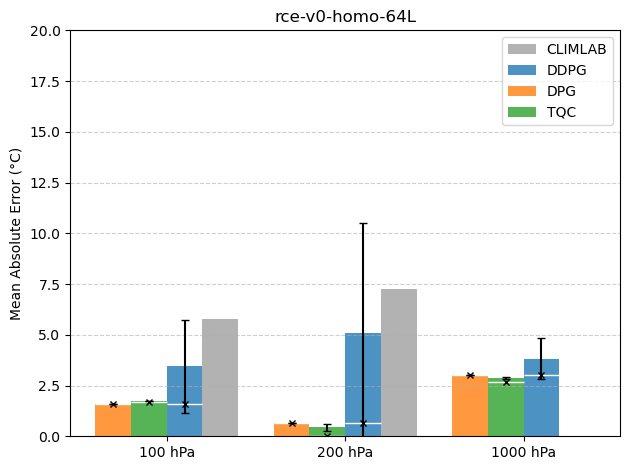

In [11]:
records = get_records(record_fns)
plot_level_errors(records, EXPERIMENT_ID)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/it]


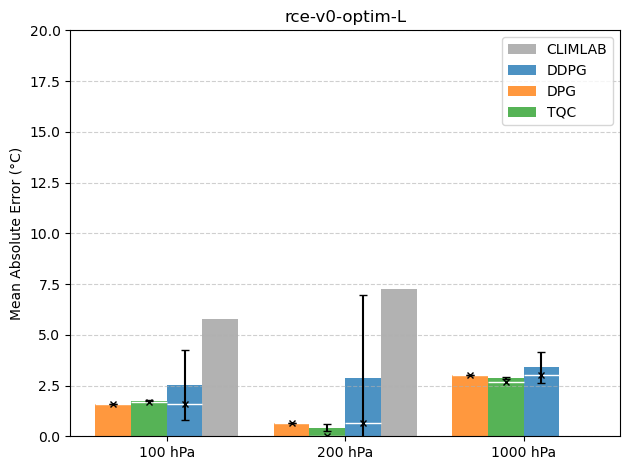

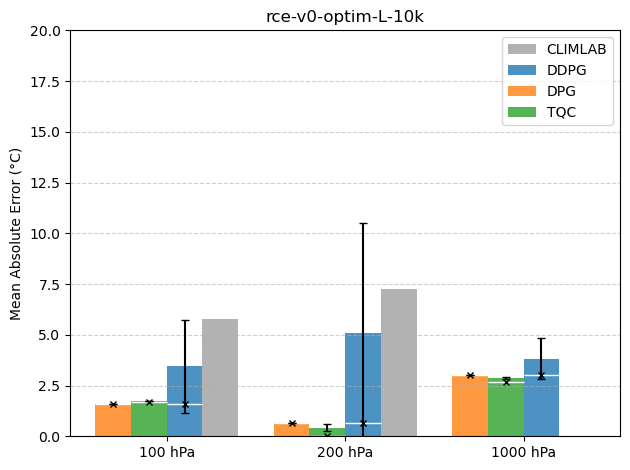

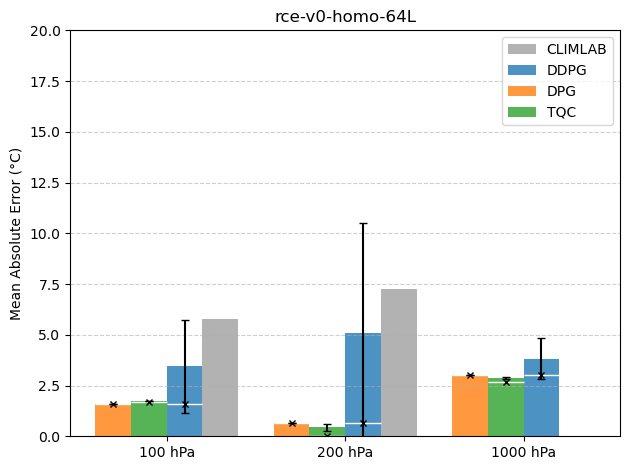

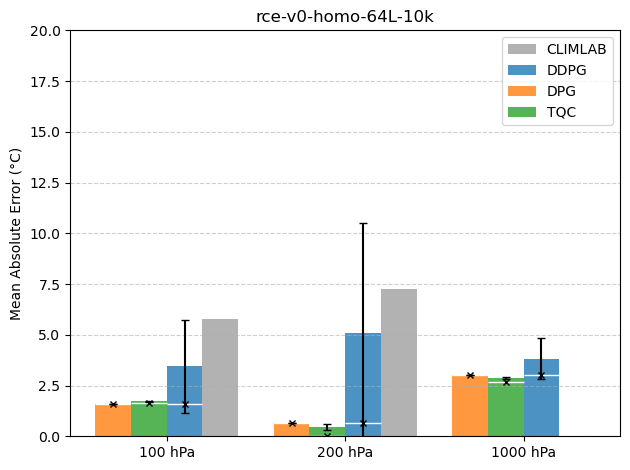

In [12]:
EXPERIMENT_IDS = [
    "rce-v0-optim-L",
    "rce-v0-optim-L-10k",
    "rce-v0-homo-64L",
    "rce-v0-homo-64L-10k",
]

for exp_id in tqdm.tqdm(EXPERIMENT_IDS):
    record_fns = get_record_fns(exp_id)
    records = get_records(record_fns)
    plot_level_errors(records, exp_id)